8.8

In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

In [79]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.linear_model import (LinearRegression,
                                  Ridge)
from sklearn.model_selection import (cross_val_score,
                                     train_test_split)
from matplotlib.pyplot import subplots
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
                             (RandomForestRegressor as RF,
                             GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import warnings; warnings.simplefilter('ignore')

cars = load_data('Carseats')
cars.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


(a)

Split the data set into a training set and a test set.

In [80]:
np.random.seed(42)
cars_train, cars_test = train_test_split(cars, test_size=0.33, random_state=0)

y_train, y_test = cars_train['Sales'], cars_test['Sales']
X_train, X_test = cars_train.drop(['Sales'],axis=1), cars_test.drop(['Sales'],axis=1)

In [81]:
def getX(data):
    model = MS(data.columns)
    D = model.fit_transform(data)
    return D

(b)

Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [82]:
X_new = getX(X_train)
feature_names = list(X_new.columns)
X_new = np.asarray(X_new)
reg = DTR(max_depth=3,random_state=0)
model = reg.fit(X_new,y_train)
X_new

array([[  1., 127.,  92., ...,  18.,   1.,   0.],
       [  1., 159.,  80., ...,  18.,   1.,   0.],
       [  1., 138.,  61., ...,  14.,   1.,   1.],
       ...,
       [  1., 145.,  53., ...,  12.,   1.,   0.],
       [  1., 126.,  98., ...,  16.,   1.,   0.],
       [  1., 104., 102., ...,  16.,   1.,   1.]])

[Text(0.5, 0.875, 'ShelveLoc[Good] <= 0.5\nsquared_error = 8.51\nsamples = 268\nvalue = 7.372'),
 Text(0.25, 0.625, 'ShelveLoc[Medium] <= 0.5\nsquared_error = 6.398\nsamples = 217\nvalue = 6.719'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Price <= 102.5\nsquared_error = 5.251\nsamples = 71\nvalue = 5.159'),
 Text(0.0625, 0.125, 'squared_error = 4.795\nsamples = 21\nvalue = 6.697'),
 Text(0.1875, 0.125, 'squared_error = 4.031\nsamples = 50\nvalue = 4.512'),
 Text(0.375, 0.375, 'Price <= 127.0\nsquared_error = 5.195\nsamples = 146\nvalue = 7.478'),
 Text(0.3125, 0.125, 'squared_error = 4.202\nsamples = 99\nvalue = 8.183'),
 Text(0.4375, 0.125, 'squared_error = 4.04\nsamples = 47\nvalue = 5.995'),
 Text(0.75, 0.625, 'Price <= 97.5\nsquared_error = 7.966\nsamples = 51\nvalue = 10.15'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'CompPrice <= 120.5\nsquared_error = 3.458\nsamples = 14\nvalue = 12.916'),
 Text(0.5625, 0.125, 'squared_error = 1.805\nsamples = 9\nvalue = 11.9

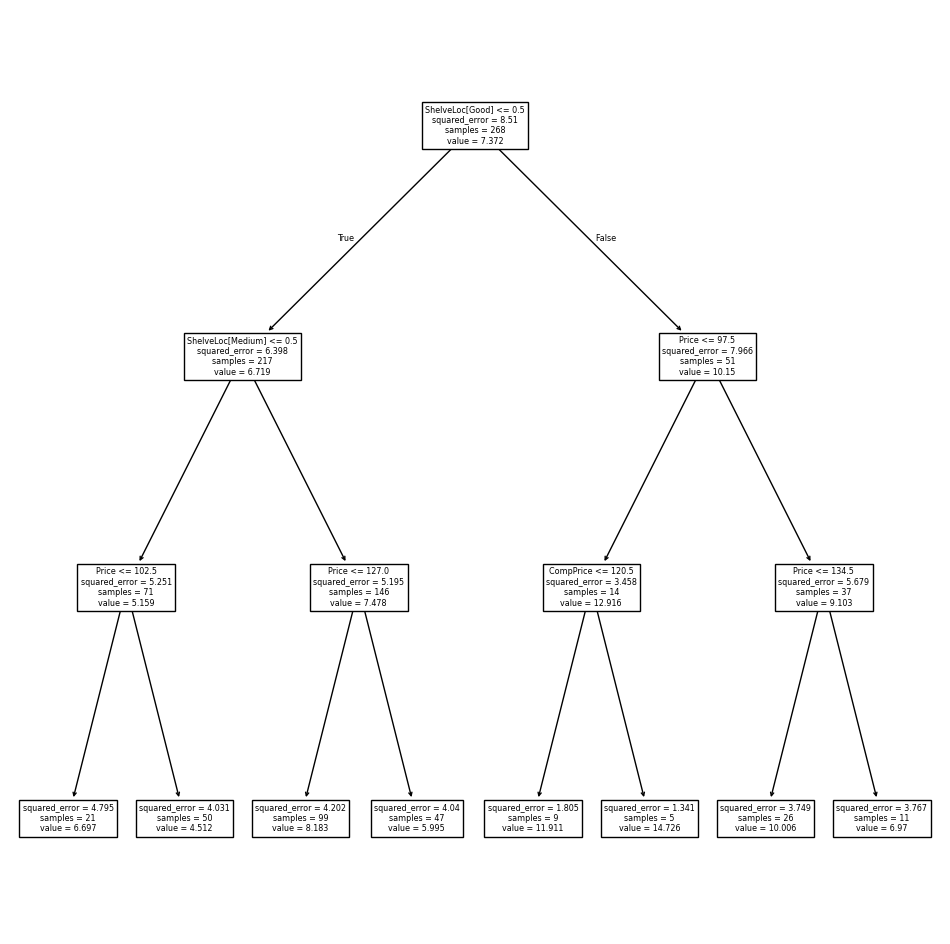

In [83]:
ax = subplots(figsize=(12,12))[1]
plot_tree(model,feature_names=feature_names,ax=ax)

The starting node in the tree is shelve location, that is if the quality of the shelve location is not good we go down to the left of the tree, otherwise we go down the right branch. If we were to go down the left branch we can see the next comparison is if the shelve location is of a medium quality we either go down the left branch or right branch, note the left branch is if the shelve location is of a bad quality and right is medium quality. In the bad quality branch we can see that if the price of the car seat is lower we sell more car seats than in the higher price, see value.

If we go down the medium quality branch we can see that if the price is $\leq 127$ we sell around 8 units otherwise we sell around 6.

In [84]:
X_new_test = getX(X_test)
X_new_test = np.asarray(X_new_test)
pred = model.predict(X_new_test)
print("MSE = ",np.mean((y_test - pred)**2))

MSE =  4.102565205847728


___________________________________________________________

(c)

Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [85]:
ccp_path = reg.cost_complexity_pruning_path(X_new,y_train)

kfold = skm.KFold(5,
                 random_state=0,
                 shuffle=True)
grid = skm.GridSearchCV(reg,
                       {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                       cv=kfold,
                       scoring='neg_mean_squared_error')
g = grid.fit(X_new,y_train)
best_ = grid.best_estimator_
np.mean((y_test - best_.predict(X_new_test))**2)

4.102565205847728

In [86]:
np.mean((y_test - pred)**2) == np.mean((y_test - best_.predict(X_new_test))**2)

True

No I get the same MSE value.

(d)

Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the $\verb|feature_importance_|$ values to determine which variables are most important.

In [87]:
bag_carseats = RF(max_features=X_new.shape[1], random_state=0)
bagc = bag_carseats.fit(X_new, y_train)
y_hat_bag = bagc.predict(X_new_test)
print("Test MSE = ",np.mean((y_test - y_hat_bag)**2))

Test MSE =  2.13030135780303


In [76]:
feature_imp = pd.DataFrame(
    {'importance': bagc.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance',ascending=False)

,importance
Price,0.284409
ShelveLoc[Good],0.209885
Age,0.108561
ShelveLoc[Medium],0.094819
CompPrice,0.089430
Advertising,0.068905
Income,0.055557
Population,0.044526
Education,0.032124
US[Yes],0.008026


(e)

Use random forests to analyze this data. What test MSE do you obtain? Use the $\verb|feature_importance_|$ values to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [88]:
forest_carseats = RF(max_features=int(np.sqrt(X_new.shape[1])), random_state=0)
forestc = forest_carseats.fit(X_new, y_train)
y_hat_bag = forestc.predict(X_new_test)
print("Test MSE = ",np.mean((y_test - y_hat_bag)**2))

Test MSE =  2.31893230090909


In [89]:
feature_imp = pd.DataFrame(
    {'importance': forestc.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance',ascending=False)

,importance
Price,0.246822
ShelveLoc[Good],0.138768
Age,0.129604
CompPrice,0.099398
Advertising,0.086376
Income,0.083722
Population,0.079936
Education,0.051510
ShelveLoc[Medium],0.046133
US[Yes],0.023863


In [94]:
feat = [k for k in range(1,20)]
feat.append('sqrt')
MSE_test = []
for i in feat:
    forest_carseats = RF(max_features=i, random_state=0)
    forestc = forest_carseats.fit(X_new, y_train)
    y_hat_bag = forestc.predict(X_new_test)
    MSE_test.append(np.mean((y_test - y_hat_bag)**2))
MSE_test

[3.377118471136365,
 2.689523067651514,
 2.31893230090909,
 2.118988755984847,
 2.2945443790151505,
 2.1249402493939376,
 2.1223006461363627,
 2.077352405984847,
 2.001864161742424,
 2.0521332431060606,
 2.101383739924242,
 2.13030135780303,
 2.13030135780303,
 2.13030135780303,
 2.13030135780303,
 2.13030135780303,
 2.13030135780303,
 2.13030135780303,
 2.13030135780303,
 2.31893230090909]

In [110]:
X_train.shape[1]

10

In [104]:
np.argmin(MSE_test) + 1

9

For m features considered at each split we can see that 1 feature at each split gives us a high MSE test error while having all of the features, without the intercept, gives us the lowest MSE test score.

(f)

Now analyze the data using BART, and report your results.

In [111]:
bart_carseats = BART(random_state=0, burnin=5, ndraw=15)
bart_carseats.fit(X_new, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [112]:
yhat_test = bart_carseats.predict(X_new_test.astype(np.float32))
np.mean((y_test- yhat_test)**2)

1.5036021994535884

Here we get the best MSE value out of Decision tree regressor, bagging and using random forest.

_________________________________________________________________________

8.9

This problem involves the OJ data set which is part of the ISLP package.

In [114]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.model_selection import (cross_val_score,
                                     train_test_split)
from matplotlib.pyplot import subplots
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
                             (RandomForestRegressor as RF,
                             GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import warnings; warnings.simplefilter('ignore')

ojs = load_data('OJ')
ojs.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


(a)

Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

In [115]:
ojs_train, ojs_test = train_test_split(ojs, train_size=800, random_state=0)

In [116]:
ojs_train.shape

(800, 18)

(b)

Fit a tree to the training data, with Purchase as the response and the other variables as predictors. What is the training error rate?

In [117]:
y_train, y_test = ojs_train['Purchase'], ojs_test['Purchase']
X_train, X_test = ojs_train.drop(['Purchase'], axis=1), ojs_test.drop(['Purchase'], axis=1)

X_new = getX(X_train)
X_new_test = getX(X_test)

# Use Gini index as criterion
reg = DTC(max_depth=3, random_state=0)
model = reg.fit(X_new,y_train)

# Predict variable then calculate error rate
pred = model.predict(X_new)
print("Training error = ", 1 - accuracy_score(y_train, pred))

Training error =  0.1775


(c)

Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?

[Text(0.5, 0.875, 'LoyalCH <= 0.509\ngini = 0.469\nsamples = 800\nvalue = [500, 300]'),
 Text(0.25, 0.625, 'LoyalCH <= 0.282\ngini = 0.413\nsamples = 340\nvalue = [99, 241]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'LoyalCH <= 0.062\ngini = 0.237\nsamples = 160\nvalue = [22, 138]'),
 Text(0.0625, 0.125, 'gini = 0.064\nsamples = 60\nvalue = [2, 58]'),
 Text(0.1875, 0.125, 'gini = 0.32\nsamples = 100\nvalue = [20, 80]'),
 Text(0.375, 0.375, 'PriceDiff <= 0.05\ngini = 0.49\nsamples = 180\nvalue = [77, 103]'),
 Text(0.3125, 0.125, 'gini = 0.32\nsamples = 70\nvalue = [14, 56]'),
 Text(0.4375, 0.125, 'gini = 0.489\nsamples = 110\nvalue = [63, 47]'),
 Text(0.75, 0.625, 'LoyalCH <= 0.705\ngini = 0.224\nsamples = 460\nvalue = [401.0, 59.0]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'PriceDiff <= 0.265\ngini = 0.415\nsamples = 150\nvalue = [106, 44]'),
 Text(0.5625, 0.125, 'gini = 0.498\nsamples = 87\nvalue = [46, 41]'),
 Text(0.6875, 0.125, 'gini = 0.091\nsamples = 63\nval

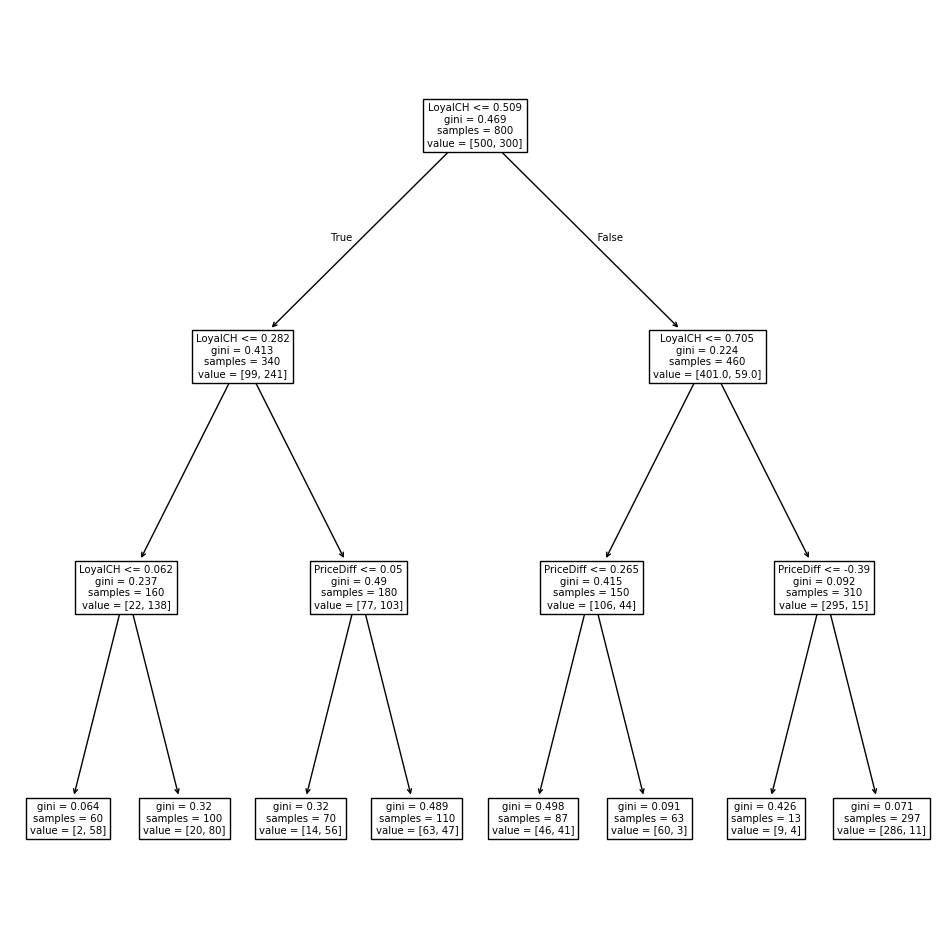

In [118]:
feature_names = list(X_new.columns)

# Plot tree
ax = subplots(figsize=(12,12))[1]
plot_tree(model,feature_names=feature_names,ax=ax)

We have 8 terminal nodes and 7 splits, i.e. $d = 7$ then terminal nodes are $d+1 = 8$.

(d)

Use the export_tree() function to produce a text summary of the fitted tree. Pick one of the terminal nodes, and interpret the information displayed.

In [119]:
print(export_text(model,
                  feature_names=feature_names,
                  show_weights=True))

|--- LoyalCH <= 0.51
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- weights: [2.00, 58.00] class: MM
|   |   |--- LoyalCH >  0.06
|   |   |   |--- weights: [20.00, 80.00] class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- weights: [14.00, 56.00] class: MM
|   |   |--- PriceDiff >  0.05
|   |   |   |--- weights: [63.00, 47.00] class: CH
|--- LoyalCH >  0.51
|   |--- LoyalCH <= 0.71
|   |   |--- PriceDiff <= 0.27
|   |   |   |--- weights: [46.00, 41.00] class: CH
|   |   |--- PriceDiff >  0.27
|   |   |   |--- weights: [60.00, 3.00] class: CH
|   |--- LoyalCH >  0.71
|   |   |--- PriceDiff <= -0.39
|   |   |   |--- weights: [9.00, 4.00] class: CH
|   |   |--- PriceDiff >  -0.39
|   |   |   |--- weights: [286.00, 11.00] class: CH



Starting from first node, i.e. weights$=[2.00, 58.00]$ with class MM=Minute maid. We see that observations 2 and 58 are in class MM because customer brand loyalty to CH (Citrus Hill) is lower or equal to $6\%$. Which in turn is lower or equal to loyalCH $28%$ and is lower or equal to $51%$. 

In other words, the customers with little to no brand loyalty to Citrus Hill will often than not choose Minute Maid (MM).
__________________________________________________________________________

(e)

Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [120]:
y_hat = model.predict(X_new_test)
confusion_table(y_hat,y_test)

Truth,CH,MM
Predicted,,
CH,138,36
MM,15,81


Here we get around $81\%$ of test observations correctly classified
_____________________________________________________________________

(f)

Use cross-validation on the training set in order to determine
 the optimal tree size.

In [121]:
max_depth = [k for k in range(1,100)]

kfold = skm.KFold(5,
                 random_state=0,
                 shuffle=True)
grid = skm.GridSearchCV(reg,
                       {'max_depth': max_depth},
                        refit=True,
                       cv=kfold,
                       scoring='neg_mean_squared_error')
grid.fit(X_new,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(max_depth=3, random_state=0),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='neg_mean_squared_error')

(g)

Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

In [122]:
cv_error = []
max_depth = [k for k in range(1,20)]

for i in max_depth:
    clf = DTC(criterion='gini',
             max_depth=i,
             random_state=0)
    clf.fit(X_new,y_train)
    kfold = skm.KFold(5,
                 random_state=0,
                 shuffle=True)
    results = skm.cross_validate(clf, X=X_new,
                                 y=y_train,
                                 cv=kfold,
                                return_train_score=True)
    cv_error.append(1-np.mean(results['train_score']))

Text(0, 0.5, 'CV classification training error')

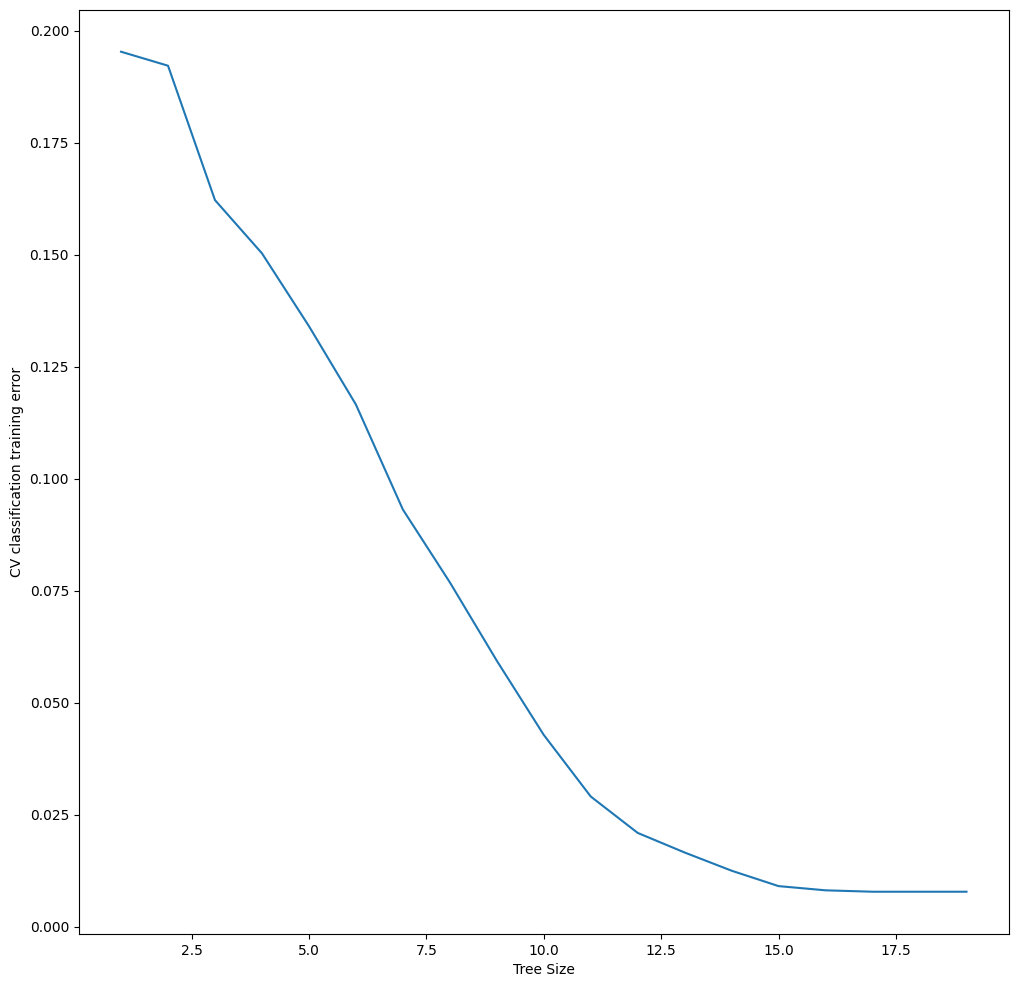

In [123]:
ax = subplots(figsize=(12,12))[1]
ax.plot(max_depth,cv_error)
ax.set_xlabel('Tree Size')
ax.set_ylabel('CV classification training error')

(h)

Which tree size corresponds to the lowest cross-validated classification error rate?

In [124]:
print("Tree size with lowest classification error : ", 1+np.argmin(cv_error))

Tree size with lowest classification error :  17


(i)

Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

[Text(0.5, 0.9285714285714286, 'LoyalCH <= 0.509\ngini = 0.469\nsamples = 800\nvalue = [500, 300]'),
 Text(0.16666666666666666, 0.7857142857142857, 'LoyalCH <= 0.282\ngini = 0.413\nsamples = 340\nvalue = [99, 241]'),
 Text(0.3333333333333333, 0.8571428571428572, 'True  '),
 Text(0.08333333333333333, 0.6428571428571429, 'gini = 0.237\nsamples = 160\nvalue = [22, 138]'),
 Text(0.25, 0.6428571428571429, 'PriceDiff <= 0.05\ngini = 0.49\nsamples = 180\nvalue = [77, 103]'),
 Text(0.16666666666666666, 0.5, 'gini = 0.32\nsamples = 70\nvalue = [14, 56]'),
 Text(0.3333333333333333, 0.5, 'SalePriceMM <= 2.205\ngini = 0.489\nsamples = 110\nvalue = [63, 47]'),
 Text(0.25, 0.35714285714285715, 'WeekofPurchase <= 246.5\ngini = 0.466\nsamples = 92\nvalue = [58, 34]'),
 Text(0.16666666666666666, 0.21428571428571427, 'STORE <= 2.5\ngini = 0.498\nsamples = 30\nvalue = [14, 16]'),
 Text(0.08333333333333333, 0.07142857142857142, 'gini = 0.461\nsamples = 25\nvalue = [9, 16]'),
 Text(0.25, 0.0714285714285714

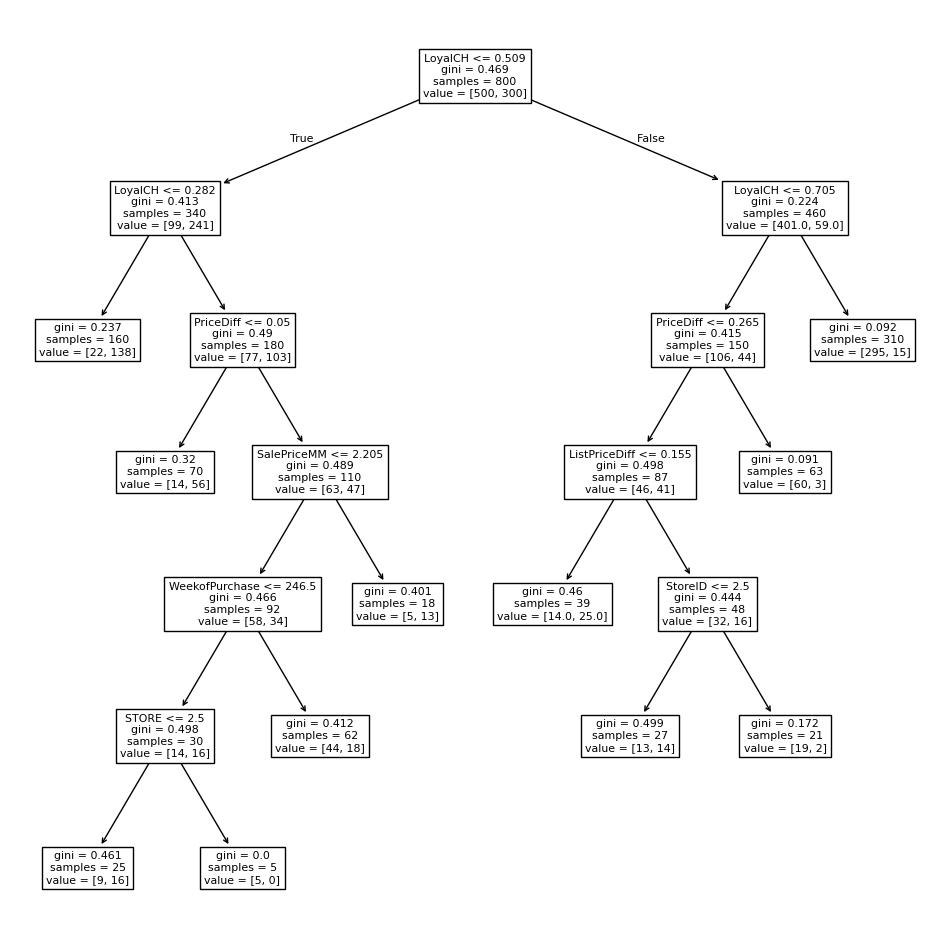

In [125]:
clf = DTC(criterion='gini',max_depth=17,random_state=0)
ccp_path = clf.cost_complexity_pruning_path(X_new,y_train)
kfold = skm.KFold(5,
                 random_state=1,
                 shuffle=True)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_new,y_train)
best = grid.best_estimator_
ax = subplots(figsize=(12,12))[1]
plot_tree(best,
         feature_names=feature_names,
         ax=ax)

In [126]:
dir(best.tree_.max_depth)
best.tree_.max_depth

6

We have a pruned tree whose maximum depth is 6 and accuracy is 

In [127]:
print(100*accuracy_score(y_test,best.predict(X_new_test)),'%')

77.77777777777779 %


(j)

Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [131]:
pr_err = 1-accuracy_score(y_train,best.predict(X_new))
model = clf.fit(X_new,y_train)
unpr_err = 1-accuracy_score(y_train,model.predict(X_new))

print("Training error for pruned is: {:.2f} | Training error for unpruned is : {:.2f}".format(pr_err*100,unpr_err*100))

Training error for pruned is: 14.38 | Training error for unpruned is : 1.12


We see that the training error for unpruned is lower than for the pruned tree.
____________________________________________________________

(k)

Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [132]:
pr_err = 1-accuracy_score(y_test,best.predict(X_new_test))
model = clf.fit(X_new,y_train)
unpr_err = 1-accuracy_score(y_test,model.predict(X_new_test))

print("Test error for pruned is: {:.2f} | Test error for unpruned is : {:.2f}".format(pr_err*100,unpr_err*100))

Test error for pruned is: 22.22 | Test error for unpruned is : 25.19


And as expected the test error for the pruned tree is lower than it is for unpruned
_________________________________________________________________

8.10

We now use boosting to predict Salary in the Hitters data set.

In [211]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import (LinearRegression,
                                  Ridge)
from sklearn.model_selection import (cross_val_score,
                                     train_test_split)
from matplotlib.pyplot import subplots
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
                             (RandomForestRegressor as RF,
                             GradientBoostingRegressor as GBR)
from ISLP.bart import BART
import warnings; warnings.simplefilter('ignore')

Hitter = load_data('Hitters')
Hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


(a)

Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [212]:
Hitter = Hitter.dropna()
Hitter['LogSalary'] = np.log(Hitter.Salary)

(b)

Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [213]:
Hitter_train, Hitter_test = train_test_split(Hitter,train_size=200, random_state=0)

X_train, X_test = Hitter_train.drop(['Salary','LogSalary'],axis=1), Hitter_test.drop(['Salary','LogSalary'],axis=1)
y_train, y_test = Hitter_train['LogSalary'], Hitter_test['LogSalary']

(c)

Perform boosting on the training set with 1,000 trees for a range of values of the shrinkage parameter. Produce a plot with different shrinkage values on the x-axis and the corresponding training set MSE on the y-axis.

In [214]:
X_new = getX(X_train)
X_new_test = getX(X_test)

In [215]:
learn = [0,0.0000001,0.000001, 0.00001,0.0001,0.001]
MSE_err = []
for lr in learn:
    boost_hit = GBR(n_estimators=1000,learning_rate=lr,random_state=0)
    bmodel = boost_hit.fit(X_new,y_train)
    pred = bmodel.predict(X_new)
    MSE_err.append(np.mean((y_train - pred)**2))
    

[0, 1e-07, 1e-06, 1e-05, 0.0001, 0.001]

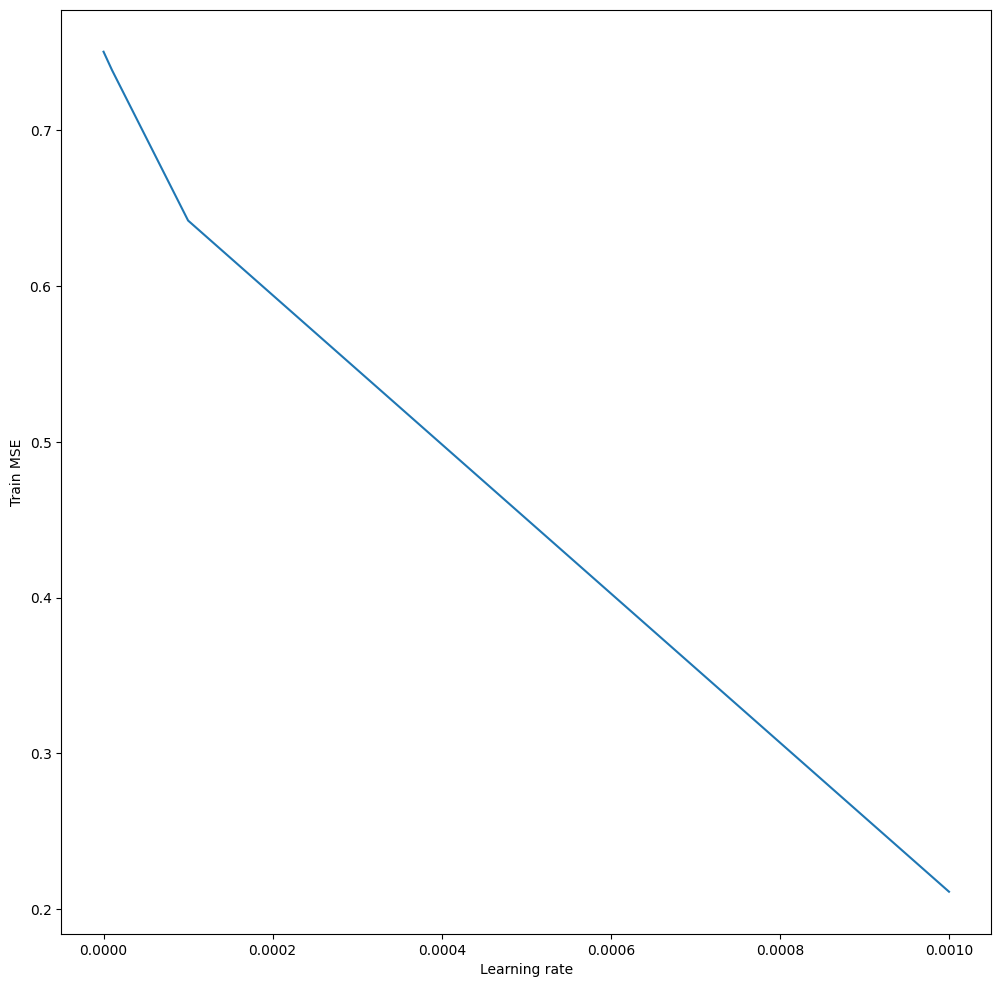

In [216]:
ax = subplots(figsize=(12,12))[1]
ax.plot(learn,MSE_err)
ax.set_xlabel('Learning rate')
ax.set_ylabel('Train MSE')
learn

(d)

Produce a plot with different shrinkage values on the x-axis and the corresponding test set MSE on the y-axis.

In [217]:
learn = [0.0005,0.001, 0.01,0.1,1, 10, 100]
MSE_err = []
for lr in learn:
    boost_hit = GBR(n_estimators=1000,learning_rate=lr,random_state=0)
    bmodel = boost_hit.fit(X_new,y_train)
    pred = bmodel.predict(X_new_test)
    MSE_err.append(np.mean((y_test - pred)**2))

[0.0005, 0.001, 0.01, 0.1, 1, 10, 100]

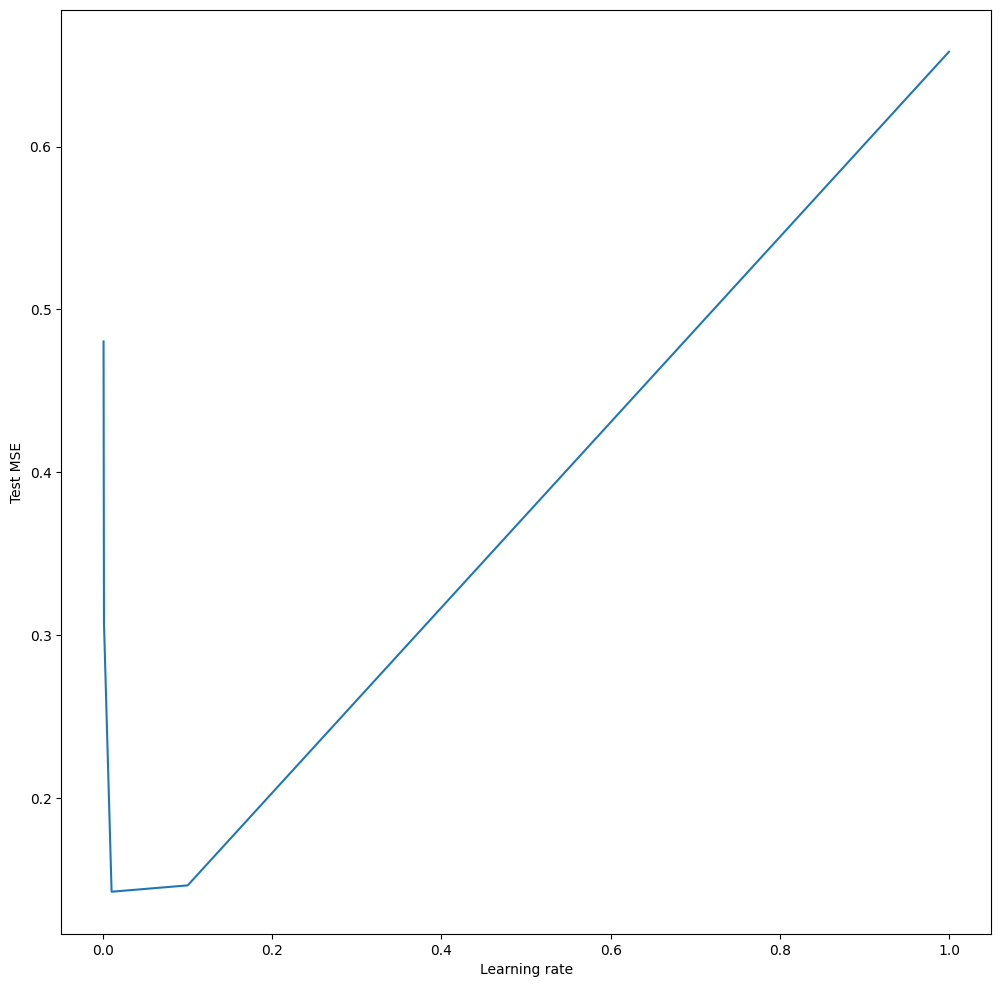

In [218]:
ax = subplots(figsize=(12,12))[1]
ax.plot(learn,MSE_err)
ax.set_xlabel('Learning rate')
ax.set_ylabel('Test MSE')
learn

(e)

Compare the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in Chapters 3 and 6.

In [219]:
reg = LinearRegression()
ridge = Ridge()

In [220]:
model_reg = reg.fit(X_new,y_train)
model_ridge = ridge.fit(X_new,y_train)
reg_pred = model_reg.predict(X_new_test)
ridge_pred = model_ridge.predict(X_new_test)

In [221]:
print('Test MSE for Linear Regression: ',np.mean((y_test - reg_pred)**2))
print('Test MSE for Ridge Regression: ',np.mean((y_test - ridge_pred)**2))
print('Test MSE for Boosting: ',min(MSE_err))

Test MSE for Linear Regression:  0.4554944998613756
Test MSE for Ridge Regression:  0.45470270792237844
Test MSE for Boosting:  0.1424100028692205


We can clearly see that boosting produces a much better MSE on the testing set than both linear- and ridge regression perform.
______________________________________________________________________

In [234]:
max(MSE_err)

0.6582402893582991

(f)

Which variables appear to be the most important predictors in the boosted model?

In [229]:
X_new = getX(X_train)
feature_names = X_new.columns
X_new

,intercept,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
17,1.0,190,46,2,24,8,15,5,479,102,5,65,23,39,0.0,1.0,102,177,16,0.0
179,1.0,551,171,13,94,83,94,13,6090,1840,128,969,900,917,1.0,0.0,1199,149,5,1.0
128,1.0,584,158,15,70,84,42,5,2358,636,58,265,316,134,1.0,0.0,331,20,4,1.0
21,1.0,426,109,3,55,43,62,1,426,109,3,55,43,62,0.0,1.0,361,22,2,1.0
177,1.0,441,118,28,84,86,68,8,2723,750,126,433,420,309,0.0,0.0,190,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,1.0,600,139,0,94,29,60,2,1236,309,1,201,69,110,1.0,0.0,300,12,9,1.0
240,1.0,271,77,5,35,29,33,12,4933,1358,48,630,435,403,0.0,1.0,62,90,3,0.0
151,1.0,151,41,4,26,21,19,2,288,68,9,45,39,35,0.0,1.0,28,56,2,0.0
62,1.0,236,56,0,27,15,11,4,1115,270,1,116,64,57,0.0,1.0,125,199,13,0.0


In [237]:
boost_hit = GBR(n_estimators=1000,learning_rate=0.00001,random_state=0)
boost_hit.fit(X_new,y_train)

GradientBoostingRegressor(learning_rate=1e-05, n_estimators=1000,
                          random_state=0)

In [240]:
feature_imp = pd.DataFrame(
    {'importance': boost_hit.feature_importances_},
    index=feature_names)


feature_imp.sort_values(by='importance',ascending=False)
#boost_hit.feature_importances_

,importance
CAtBat,0.710586
CRBI,0.142286
Hits,0.093231
RBI,0.008060
AtBat,0.007899
CHits,0.006293
CWalks,0.006056
CRuns,0.006003
Runs,0.005465
Walks,0.005227


(g)

Now apply bagging to the training set. What is the test set MSE for this approach?

In [241]:
bag_hit = RF(max_features=X_train.shape[1],
            n_estimators=1000,
            random_state=0).fit(X_new,y_train)
y_hat = bag_hit.predict(X_new_test)
print('Test MSE from bagging : ',np.mean((y_test - y_hat)**2))

Test MSE from bagging :  0.13935920989793738


8.12

Apply boosting, bagging, random forests, and BART to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on a test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?

In [43]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.linear_model import (LinearRegression,
                                  Ridge)
from sklearn.model_selection import (cross_val_score,
                                     train_test_split)
from matplotlib.pyplot import subplots
from sklearn.pipeline import (Pipeline,
                              make_pipeline)
from statsmodels.datasets import get_rdataset
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from sklearn.linear_model import LogisticRegression
from ISLP.models import ModelSpec as MS
from sklearn.tree import (DecisionTreeClassifier as DTC, 
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
                             (RandomForestRegressor as RF,
                             GradientBoostingRegressor as GBR,
                             GradientBoostingClassifier as GBC)
from ISLP.bart import BART
import warnings; warnings.simplefilter('ignore')

caravan = load_data('Caravan')
caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


We use the caravan dataset and use Purchase as the response variable

In [44]:
X = caravan.drop(['Purchase'],axis=1)
y = caravan['Purchase']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

boost = GBC(n_estimators=1000,learning_rate=0.001,random_state=0, max_depth=1)
boost.fit(X_train,y_train)
y_pred = boost.predict(X_test)
print('Accuracy score', 1- accuracy_score(y_test,y_pred))

Accuracy score 0.06609442060085835


In [45]:
y_pred = boost.predict(X_test)
print('Accuracy score', 1- accuracy_score(y_test,y_pred))

Accuracy score 0.06609442060085835


Bagging

In [46]:
y_newtr = np.where(y_train=='Yes',1,0)

bag_car = RF(max_features=X_train.shape[1],
            n_estimators=1000,
            random_state=0).fit(X_train,y_newtr)

In [47]:
y_pred = bag_car.predict(X_test)
y_pred = np.where(y_pred>=0.5,'Yes','No')
print('Accuracy score',accuracy_score(y_test,y_pred))

Accuracy score 0.9150214592274678


Random Forest

In [48]:
rf_car = RF(max_features=int(np.sqrt(X_train.shape[1])),
            n_estimators=1000,
            random_state=0).fit(X_train,y_newtr)

In [49]:
y_pred = rf_car.predict(X_test)
y_pred = np.where(y_pred>=0.5,'Yes','No')
print('Accuracy score',accuracy_score(y_test,y_pred))

Accuracy score 0.9210300429184549


Bart

In [50]:
bart_car = BART(random_state=0).fit(X_train,y_newtr)

In [51]:
y_pred = bart_car.predict(X_test)
y_pred = np.where(y_pred>=0.5,'Yes','No')
print('Accuracy score',accuracy_score(y_test,y_pred))

Accuracy score 0.9339055793991416


In [52]:
lg_car = LogisticRegression().fit(X_train,y_train)

In [53]:
y_pred = lg_car.predict(X_test)
print('Accuracy score',accuracy_score(y_test,y_pred))

Accuracy score 0.9339055793991416


The methods that yield the best accuracy score is the BART method and Logistic regression